# Final Project Part 1: Model Acerbi et al. (2012)
## Travis Hammond - s2880024

First, let's import the basics

In [1]:
from pathlib import Path
import sys; sys.path.append(Path().resolve().parent.as_posix())  # noqa

from ACTR.model import Model
from ACTR.dmchunk import Chunk

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import rv_discrete
import pandas as pd
import numpy as np

rng = np.random.default_rng(seed=111)


def noise(s: float) -> float:
    rand = rng.uniform(0.001, 0.999)
    return s * np.log((1 - rand) / rand)


def time_to_pulses(
            time: float,
            t_0: float = 0.011,
            a: float = 1.1,
            b: float = 0.015
        ) -> int:
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses


def pulses_to_time(
            pulses: int,
            t_0: float = 0.011,
            a: float = 1.1,
            b: float = 0.015
        ) -> float:
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

Then, I define the code that executes a trial (and computes the feedback error). I took the same model as in the previous assignments because as we aim to model human cognition as closely as possible, the same model should perform similarly to humans across all similar experiments.

Time intervals are by default assumed to be uniformly distributed unless explicitly stated otherwise.

In [2]:
def get_error(interval, response, k=400, err_type='skewed'):
    # Get the error / feedback in different forms
    return {
        'skewed':     k * ((response - interval) / response),
        'fractional': k * ((response - interval) / interval),
        'standard':   k * (response - interval),
    }[err_type]


def do_trial(subj: Model, distribution) -> float:
    # Participants click the mouse after a time of their choosing to start
    # Time of their choosing is interpreted here as a uniform time in 0.5-3s
    subj.time += sum(rng.uniform(0.500, 3.000, size=1))  # click

    # x ms delay (sampled from distribution), then the yellow dot was flashed
    sample_interval = distribution.rvs(1) / 1000
    subj.time += sample_interval  # flash

    # Take the same model as in the previous homeworks as a baseline
    # Convert time to pulses and remember how many it took
    counted_pulses = time_to_pulses(sample_interval)
    subj.add_encounter(Chunk(
        name=f'pf_{counted_pulses}',
        slots={'isa': 'pulse-fact', 'pulses': counted_pulses}
    ))

    # Flash is shown for 18.5ms
    subj.time += 0.0185  # end flash

    # Retrieve a blended trace
    request = Chunk(
        name='pulse-request',
        slots={'isa': 'pulse-fact'}
    )
    estimated_pulses, _ = subj.retrieve_blended_trace(request, 'pulses')
    # Convert pulses back to time
    response_interval = pulses_to_time(estimated_pulses)

    # Subjects were required to wait at least 250ms before reproducing.
    # 'at least' is interpreted here as a uniform distribution from 250-350ms
    # TODO: i guess it would actually be more skewed towards 250ms and truncated
    subj.time += sum(rng.uniform(0.250, 0.350, size=1))  # end wait

    # Interval is estimated and reproduced by holding the mouse click
    subj.time += response_interval  # release mouse click

    # Feedback is represented after a uniformly sampled delay (450-850ms)
    subj.time += sum(rng.uniform(0.450, 0.850, size=1))  # end delay

    # Feedback is presented for 62ms
    error = get_error(sample_interval, response_interval)
    subj.time += 0.062  # end feedback

    # Fixation cross disappears after 500-750ms, followed by a blank screen for
    # another 500-750ms and then the trial restarts. interpreted as uniform.
    subj.time += sum(rng.uniform(0.500, 0.750, size=2))

    return sample_interval, response_interval, error


Then a small detour to some basic-ish plotting code to reproduce Figures 3+4 of Acerbi et al. (2012).

In [3]:
def subplot(ax, data: pd.DataFrame, plot_type: str) -> None:
    assert plot_type in ['mean', 'std']

    # Extract and sort the interval values
    xticks = pd.unique(data['interval']) * 1000
    xticks.sort()

    # Group by distribution first to separate conditions
    for dist_val, dist_group in data.groupby('distribution'):

        # Group by interval and get mean reponse bias and s.e.m
        yvals, yerr = ([], [])
        for int_val, int_group in dist_group.groupby('interval'):

            # Compute yval based on plot_type
            val = getattr((int_group['response'] * 1000), plot_type)()
            if plot_type == 'mean': val -= int_val * 1000
            yvals.append(val)

            # Compute the s.e.m
            yerr.append((int_group['response'] * 1000).sem())

        # Slice the first 6 or the last 6 xticks depending on last int_val
        start, stop = (None, 6) if int_val * 1000 == xticks[5] else (-6, None)
        # Plot the points and the errorbars
        ax.errorbar(
            xticks[start:stop], yvals, yerr=yerr, label=dist_val,
            marker='o', markeredgewidth=1, markeredgecolor='black',
            linewidth=0, elinewidth=1, ecolor='black', capsize=2,
        )

    # Configure the plot (ax limits and null line)
    ax.set_ylim(-150, 150) if plot_type == 'mean' else ax.set_ylim(40, 120)
    ax.set_xlim(min(xticks) - 50, max(xticks) + 50)
    ax.hlines(0, *ax.get_xlim(), colors='gray', ls='-', lw=1)


def plot(spec: dict, data: pd.DataFrame) -> None:
    # Consider a single randomly chosen subject
    single = data[data['subject'] == rng.choice(pd.unique(data['subject']))]

    # Create subplots
    fig, axs = plt.subplots(3, 2, gridspec_kw={'height_ratios': [1, 5, 5]})
    fig.set_size_inches(12, 14)
    ((h1, h2), (s_mean, g_mean), (s_std, g_std)) = axs

    # Get distributions and create top row histograms
    dist1, dist2 = spec['blocks']
    xticks = np.unique(np.concatenate((dist1.xk, dist2.xk)))
    # Make sure the peaked dist goes on top, and the shorter dist below
    if not all(dist1.pk == dist1.pk[0]) or dist1.xk[0] > dist2.xk[0]:
        (dist1, dist2) = (dist2, dist1)
    for hist in [h1, h2]:
        hist.bar(dist1.xk, dist1.pk, width=20)
        hist.bar(dist2.xk, dist2.pk, width=20, bottom=dist1.pk + 0.2)
        hist.set_xticks(xticks)
        hist.set_yticks([])

    # Populate the rest of the plots (bottom two rows)
    subplot(s_mean, single, 'mean')
    s_mean.set_title('Single subject')
    s_mean.set_ylabel('Response bias (ms)')

    subplot(g_mean, data, 'mean')
    g_mean.set_title('Group mean')
    g_mean.text(900, 100, 'n = {}'.format(spec['n_subj']), fontsize=14)

    subplot(s_std, single, 'std')
    s_std.set_xlabel('Physical time interval (ms)')
    s_std.set_ylabel('Response sd (ms)')

    subplot(g_std, data, 'std')
    g_std.set_xlabel('Physical time interval (ms)')

    # Global legend positioning is quite shit but better than nothing
    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc='lower center')

    [ax.set_xticks(xticks) for ax in axs.flatten()]
    fig.suptitle(spec['name'])
    fig.tight_layout()
    #fig.show()

Now I can define the experiment loop and the experiments themselves, which I chose to bundle in a dictionary containing experiment specific information and the distributions themselves.

In [4]:
def do_experiment(spec: dict) -> pd.DataFrame:
    data = list()

    # Subject loop
    for subj_id, subj in [(id, Model()) for id in range(spec['n_subj'])]:

        # Block loop
        rng.shuffle(spec['blocks'])
        for distribution in spec['blocks']:

            # Session / Trial loops (2 training sessions, 2 testing sessions)
            for sess_idx in range(4):
                # Session are fixed at 500 Trials to simplify things
                for trial_idx in range(500):

                    # Do trial
                    interval, response, error = do_trial(subj, distribution)

                    # Collect data (ignore training sessions)
                    if sess_idx < 2: continue
                    data.append([
                        interval, response, error,
                        distribution.name, subj_id,
                        sess_idx, trial_idx
                    ])

                # Between session break
                subj.time += 30

            # Between block break
            subj.time += 60

    return pd.DataFrame(data=data, columns=[
        'interval', 'response', 'feedback',
        'distribution', 'subject',
        'session_idx', 'trial_idx',
    ])


# Define Experiment1
exp1 = {
    # Unfortunately, scipy's custom discrete distributions only accept integer
    # value ranges, so these are defined in terms of ms and not s as units.
    'name': 'Experiment 1',
    'n_subj': 4,
    'blocks': np.array([
        rv_discrete(name='short', seed=rng, values=(
                np.linspace(start=450, stop=825, num=6),
                np.repeat(1/6, 6),
            ),
        ),
        rv_discrete(name='long', seed=rng, values=(
                np.linspace(start=750, stop=1125, num=6),
                np.repeat(1/6, 6),
            ),
        ),
    ])
}

# Define Experiment2
exp2 = {
    'name': 'Experiment 2',
    'n_subj': 6,
    'blocks': np.array([
        rv_discrete(name='medium', seed=rng, values=(
                np.linspace(start=600, stop=975, num=6),
                np.repeat(1/6, 6),
            ),
        ),
        rv_discrete(name='medium_peaked', seed=rng, values=(
                np.linspace(start=600, stop=975, num=6),
                np.array([1/12, 7/12, 1/12, 1/12, 1/12, 1/12]),
            ),
        ),
    ])
}

Finally, let's see how the basic model performs

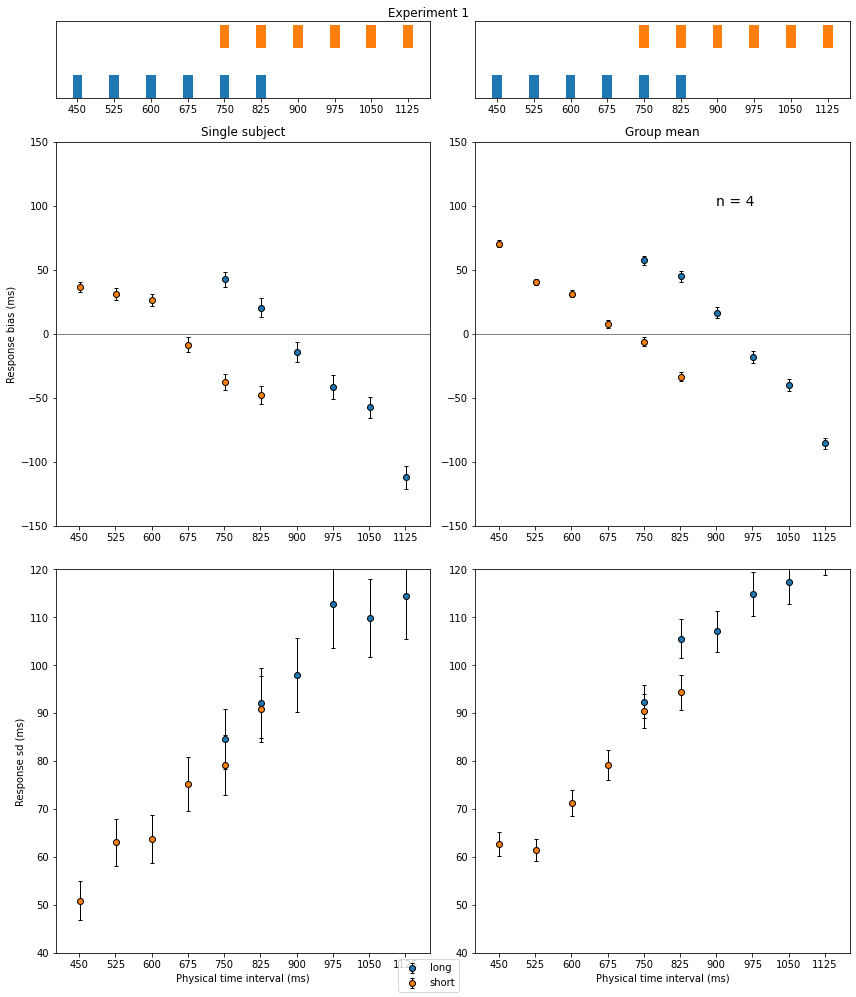

In [5]:
plot(exp1, do_experiment(exp1))

As we can see, it actually does quite well. Let's try Experiment 2:

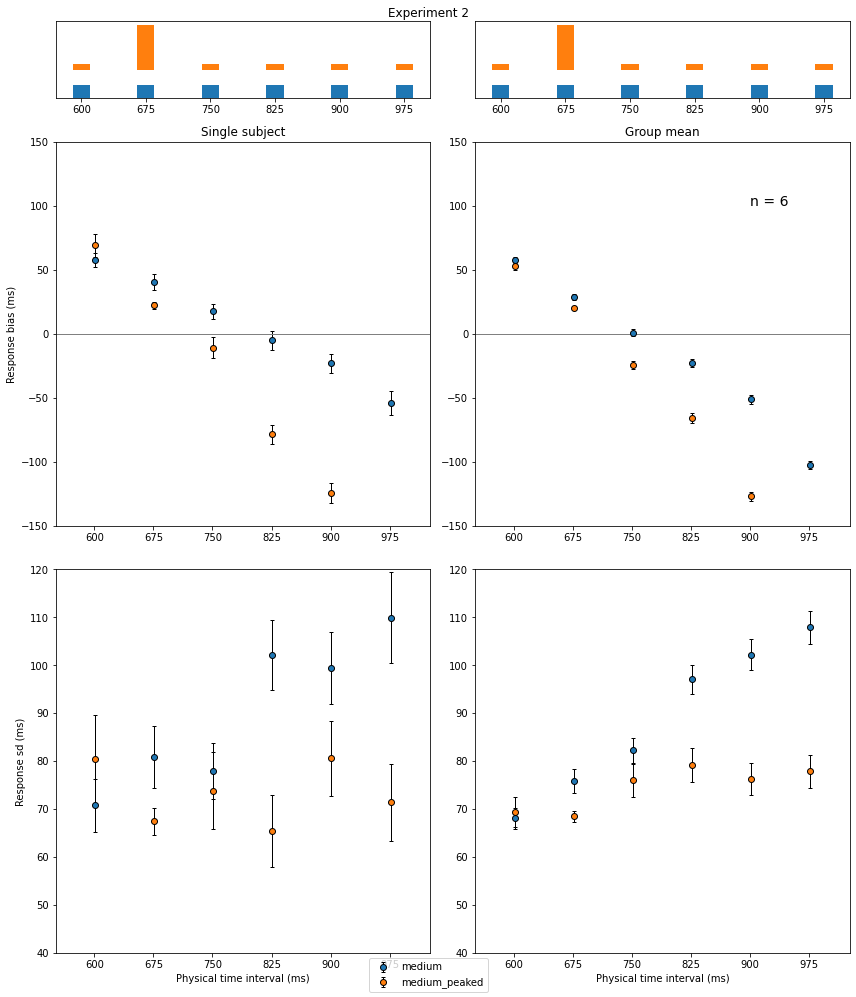

In [6]:
plot(exp2, do_experiment(exp2))

Now let's try a small modification to the model. Right now, the feedback is not modeled apart from a time increment of 62ms. I assume that the current functioning of the model is unchanged by the feedback because the feedback occurs after the actual trial (i.e. estimating the interval, retrieving a blended trace, etc). The feedback just provides an additional opportunity to create a new memory, slightly adjusted by the type (too short / too long) and magnitude of the error. For example:

- The subject counts pulses and as soon as the presented interval is finished, a memory is created and stored containing the pulse count
- The subject requests a blended trace of type pulses and takes a guess with the returned value
- The subject receives feedback and takes a guess at how many pulses too many/little. With the new pulse count estimate, a new memory is made

We add this modification in the do_trial function, the only change is just before the feedback time increment of 62ms. The feedback/error range was experimentally determined to be within the range \[-300, 300\], and the pulses for the full range of sample intervals was in \[15, 30\]. So, I decided that a correction of at most 10 pulses, linearly proportional to the error feedback, was justifiable. This can be done by simply dividing the error by 30.

In [7]:
def do_trial(subj: Model, distribution) -> float:
    # Participants click the mouse after a time of their choosing to start
    # Time of their choosing is interpreted here as a uniform time in 0.5-3s
    subj.time += sum(rng.uniform(0.500, 3.000, size=1))  # click

    # x ms delay (sampled from distribution), then the yellow dot was flashed
    sample_interval = distribution.rvs(1) / 1000
    subj.time += sample_interval  # flash

    # Take the same model as in the previous homeworks as a baseline
    # Convert time to pulses and remember how many it took
    counted_pulses = time_to_pulses(sample_interval)
    subj.add_encounter(Chunk(
        name=f'pf_{counted_pulses}',
        slots={'isa': 'pulse-fact', 'pulses': counted_pulses}
    ))

    # Flash is shown for 18.5ms
    subj.time += 0.0185  # end flash

    # Retrieve a blended trace
    request = Chunk(
        name='pulse-request',
        slots={'isa': 'pulse-fact'}
    )
    estimated_pulses, _ = subj.retrieve_blended_trace(request, 'pulses')
    # Convert pulses back to time
    response_interval = pulses_to_time(estimated_pulses)

    # Subjects were required to wait at least 250ms before reproducing.
    # 'at least' is interpreted here as a uniform distribution from 250-350ms
    # TODO: i guess it would actually be more skewed towards 250ms
    subj.time += sum(rng.uniform(0.250, 0.350, size=1))  # end wait

    # Interval is estimated and reproduced by holding the mouse click
    subj.time += response_interval  # release mouse click

    # Feedback is represented after a uniformly sampled delay (450-850ms)
    subj.time += sum(rng.uniform(0.450, 0.850, size=1))  # end delay

    # Make a correction and form/reinforce a new memory based on that
    error = get_error(sample_interval, response_interval)
    new_pulse_estimate = int(estimated_pulses + (error / 30))
    subj.add_encounter(Chunk(
        name=f'pf_{new_pulse_estimate}',
        slots={'isa': 'pulse-fact', 'pulses': new_pulse_estimate}
    ))
    # Feedback is presented for 62ms
    subj.time += 0.062  # end feedback

    # Fixation cross disappears after 500-750ms, followed by a blank screen for
    # another 500-750ms and then the trial restarts. interpreted as uniform.
    subj.time += sum(rng.uniform(0.500, 0.750, size=2))

    return sample_interval, response_interval, error

Let's see how it performs now:

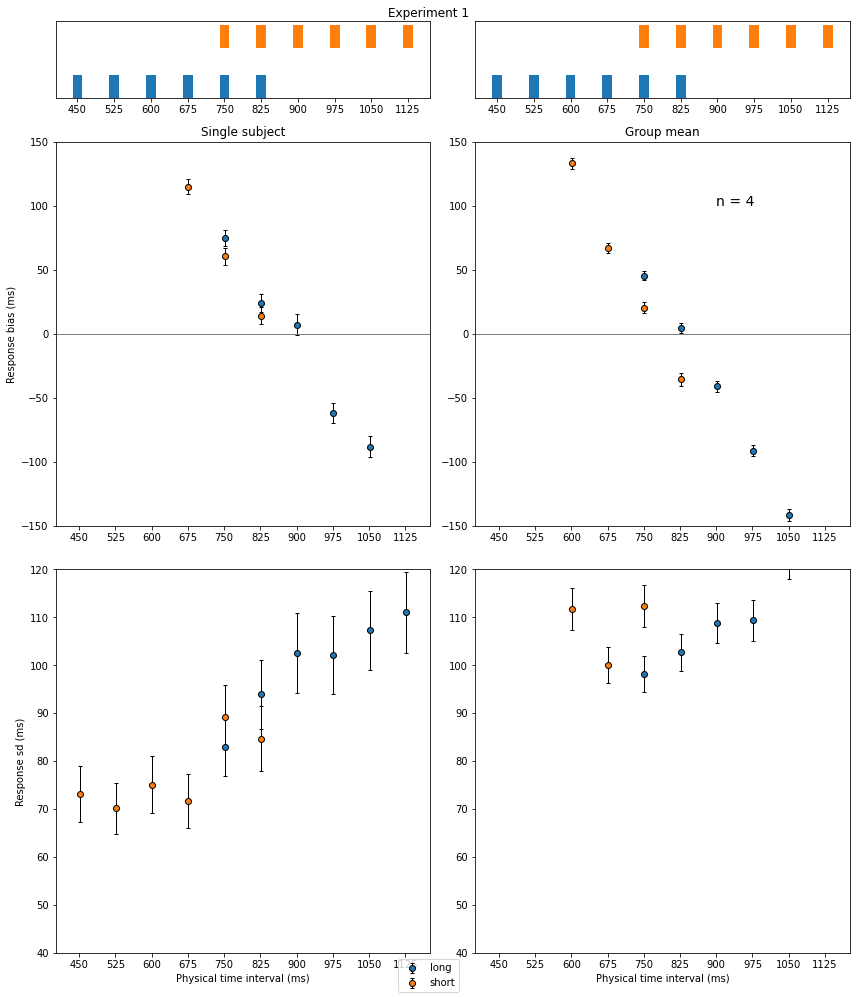

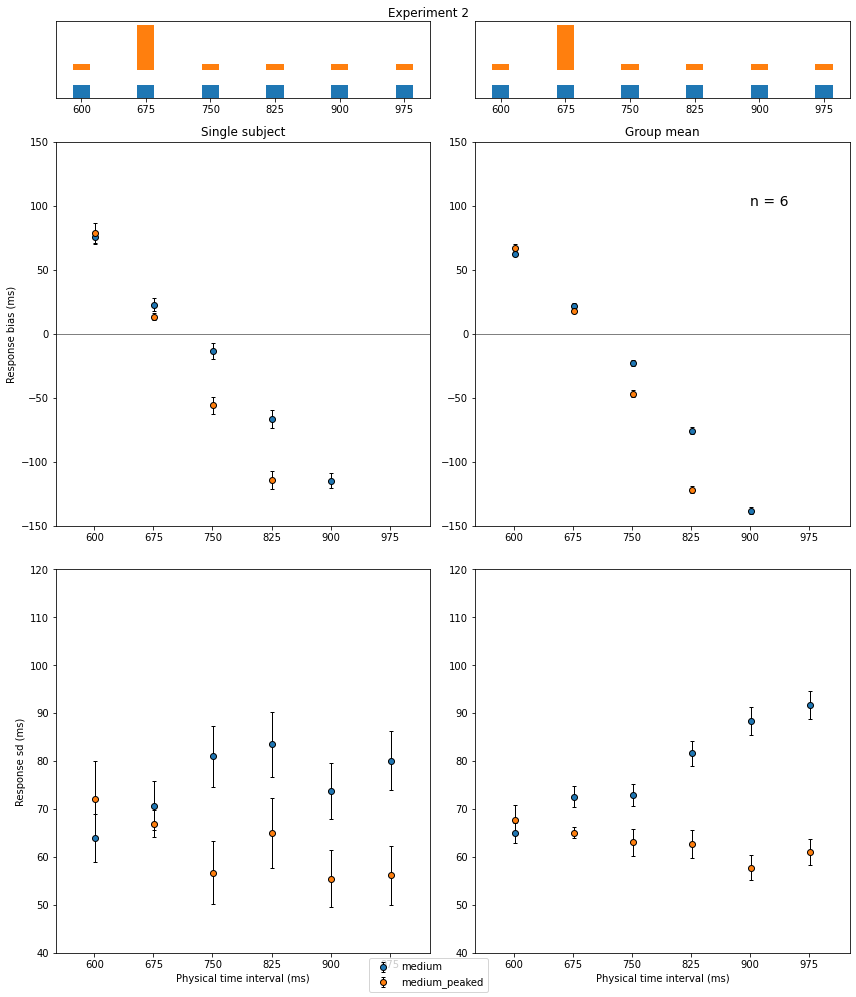

In [8]:
plot(exp1, do_experiment(exp1))
plot(exp2, do_experiment(exp2))

As we can see, it did not improve the fit on either of the experiments. Due to severe time constraints I will have to stop here.

One thing to say though, is that the original model performed quite similarly to the human data on both experiments but experiment 1 in particular. Experiment 2 showed some similarities but the group mean drifts apart consistently instead of staying roughly parallel to each other. In both experiments, the response bias shows a consistently better fit than the standard deviation. This is all probably due to the fact that I simply took the original model and made no improvements.